In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy  as np
import math

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder

from tqdm import tqdm

In [3]:

ticker         = params.ticker
look_back      = params.look_back_tick 
features_cols  = params.features_cols
label_col      = params.label_col
save_path      = params.save_path

date = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
regular_start_pred  = params.regular_start_pred

save_path = params.save_path
in_path   = save_path / f"{ticker}_ready.csv"
out_path  = save_path / f"{ticker}_final.csv"

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

df_raw = pd.read_csv(in_path, index_col=0, parse_dates=True)
df  = models.feature_engineering(df_raw)
df

Using device: cuda


,open,high,low,close,volume,r_1,r_5,r_15,vol_15,volume_spike,vwap_dev,rsi_14,bid,ask,signal_smooth
2014-04-03 12:06:00,28.644845,28.644845,28.644845,28.644845,4580.0,-0.000180,-0.000180,-0.000180,0.000046,0.568641,-0.000175,0.000000,28.636251,28.653438,0.102454
2014-04-03 12:07:00,28.639690,28.639690,28.639690,28.639690,4540.0,-0.000180,-0.000360,-0.000360,0.000063,0.570338,-0.000347,0.000000,28.631098,28.648282,0.103267
2014-04-03 12:08:00,28.634534,28.634534,28.634534,28.634534,4500.0,-0.000180,-0.000540,-0.000540,0.000075,0.574408,-0.000514,0.000000,28.625944,28.643125,0.104129
2014-04-03 12:09:00,28.629379,28.629379,28.629379,28.629379,4460.0,-0.000180,-0.000720,-0.000720,0.000082,0.581017,-0.000678,0.000000,28.620791,28.637968,0.105040
2014-04-03 12:10:00,28.624224,28.624224,28.624224,28.624224,4420.0,-0.000180,-0.000900,-0.000900,0.000088,0.590413,-0.000839,0.000000,28.615637,28.632811,0.105999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-17 20:56:00,176.090000,176.160000,176.010000,176.050000,126589.0,-0.000284,-0.000681,-0.001297,0.000443,1.610125,1.133750,39.325843,175.997200,176.102800,0.000000
2025-06-17 20:57:00,176.050000,176.080000,175.890000,175.930000,125176.0,-0.000682,-0.000398,-0.001761,0.000469,1.478464,1.132291,34.328358,175.877200,175.982800,0.000000
2025-06-17 20:58:00,175.930000,175.975000,175.860000,175.890000,200235.0,-0.000227,-0.001023,-0.002016,0.000468,2.096227,1.131800,29.648241,175.837200,175.942800,0.000000
2025-06-17 20:59:00,175.900000,175.970000,175.800000,175.930000,393414.0,0.000227,-0.001136,-0.002073,0.000464,3.295458,1.132272,25.925926,175.877200,175.982800,0.000000


In [4]:
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=features_cols,
    label_col=label_col,
    regular_start=regular_start_pred
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)


Shapes:
  X         = torch.Size([908638, 90, 12]) (samples, look_back, features)
  y         = torch.Size([908638]) (samples,)
  raw_close = torch.Size([908638])
  raw_bid   = torch.Size([908638])
  raw_ask   = torch.Size([908638])


In [5]:
# Split into train/val/test by calendar day
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back   = look_back,
    regular_start   = regular_start_pred,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)


Shapes:
  X_tr        = torch.Size([626802, 90, 12])
  y_tr        = torch.Size([626802])
  raw_close_te= torch.Size([141410])
  raw_bid_te  = torch.Size([141410])
  raw_ask_te  = torch.Size([141410])


In [6]:

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)


▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=626802, val=140426, te=141410
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..291], total days=292
   te_day_id  ∈ [0..293], total days=294
4) instantiating DayWindowDatasets
   ds_tr days: 1376
   ds_val days: 292
   ds_te days: 294
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready


In [7]:

# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = len(features_cols),                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(device)   # place model parameters on GPU or CPU as specified

model

DualMemoryLSTM(
  (short_lstm): LSTM(12, 32, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (do_short): Dropout(p=0.3, inplace=False)
  (ln_short): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(32, 32, batch_first=True)
  (do_long): Dropout(p=0.4, inplace=False)
  (ln_long): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=32, out_features=1, bias=True)
)

In [8]:

# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0008
    lr: 0.0008
    maximize: False
    weight_decay: 0.0002
)

In [9]:
############################################
# function to find the optimal learning rate
############################################

# # 1) Move model to CPU and build a fresh optimizer (no scheduler metadata)
# model_cpu = model.cpu()
# optimizer_cpu = torch.optim.AdamW(
#     model_cpu.parameters(),
#     lr=1e-3,        # placeholder; the finder will override this
#     weight_decay=5e-4
# )

# # 2) Create a tiny DataLoader (batch_size=1) to save memory
# small_loader = DataLoader(
#     train_loader.dataset,
#     batch_size=1,
#     shuffle=True,
#     num_workers=0
# )

# # 3) Define an aligned MSE that permutes/expands your [1,1,D] or [D,1,1]
# #    target → [D, T, 1] to match output shape exactly.
# def aligned_mse(output, target):
#     # output: [D, T, 1]
#     # target might come in as [D,1,1] or [1,1,D]
#     tgt = target

#     # Case A: target == [D, 1, 1] → expand middle dim to T
#     if tgt.dim() == 3 and tgt.shape[0] == output.shape[0] \
#        and tgt.shape[1] == 1 and tgt.shape[2] == 1:
#         tgt = tgt.expand(-1, output.size(1), -1)

#     # Case B: target == [1, 1, D] → permute to [D,1,1] then expand
#     elif tgt.dim() == 3 and tgt.shape[0] == 1 \
#          and tgt.shape[1] == 1 and tgt.shape[2] == output.shape[0]:
#         # permute (0,1,2) → (2,1,0) to get [D,1,1]
#         tgt = tgt.permute(2, 1, 0)
#         tgt = tgt.expand(-1, output.size(1), -1)

#     else:
#         # fallback: broadcast to exactly output.shape
#         tgt = tgt.expand(output.shape)

#     return Funct.mse_loss(output, tgt)

# # 4) Free any lingering GPU memory
# gc.collect()
# torch.cuda.empty_cache()

# # 5) Run the LR‐Finder on CPU for just 30 mini‐batches
# lr_finder = LRFinder(
#     model_cpu,
#     optimizer_cpu,
#     aligned_mse,
#     device="cpu"
# )
# lr_finder.range_test(
#     small_loader,
#     end_lr=1,     # maximum LR to try
#     num_iter=30   # number of batches
# )
# lr_finder.plot()   # examine loss vs. LR curve
# lr_finder.reset()  # restore original model & optimizer states

# # 6) Move model back to GPU for your main training
# model = model_cpu.to("cuda")


Training sees 1376 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.296618


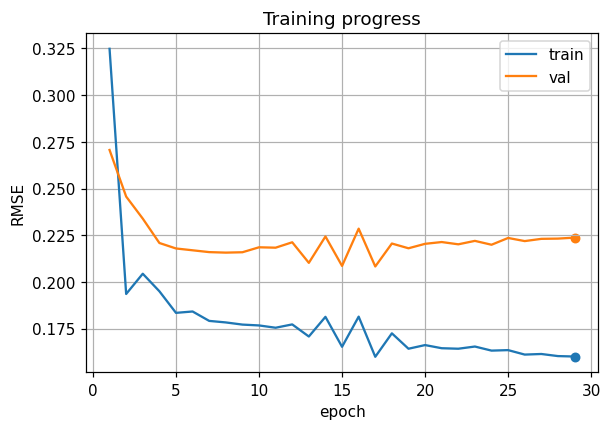

Epoch 1:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3248 • val=0.2706 • lr=8.00e-04


Epoch 2:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1935 • val=0.2457 • lr=7.98e-04


Epoch 3:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2044 • val=0.2339 • lr=7.96e-04


Epoch 4:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1950 • val=0.2208 • lr=7.92e-04


Epoch 5:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1834 • val=0.2179 • lr=7.88e-04


Epoch 6:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1841 • val=0.2169 • lr=7.83e-04


Epoch 7:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1791 • val=0.2159 • lr=7.76e-04


Epoch 8:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1783 • val=0.2157 • lr=7.69e-04


Epoch 9:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1771 • val=0.2159 • lr=7.61e-04


Epoch 10:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1767 • val=0.2185 • lr=7.52e-04


Epoch 11:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1754 • val=0.2183 • lr=7.42e-04


Epoch 12:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1772 • val=0.2212 • lr=7.32e-04


Epoch 13:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1707 • val=0.2102 • lr=7.20e-04


Epoch 14:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1813 • val=0.2243 • lr=7.08e-04


Epoch 15:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1652 • val=0.2085 • lr=6.95e-04


Epoch 16:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1814 • val=0.2285 • lr=6.81e-04


Epoch 17:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1599 • val=0.2082 • lr=6.67e-04


Epoch 18:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1724 • val=0.2205 • lr=6.52e-04


Epoch 19:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1642 • val=0.2180 • lr=6.36e-04


Epoch 20:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1661 • val=0.2204 • lr=6.20e-04


Epoch 21:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1645 • val=0.2213 • lr=6.04e-04


Epoch 22:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1642 • val=0.2201 • lr=5.87e-04


Epoch 23:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1654 • val=0.2220 • lr=5.69e-04


Epoch 24:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1632 • val=0.2199 • lr=5.52e-04


Epoch 25:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1634 • val=0.2235 • lr=5.34e-04


Epoch 26:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1611 • val=0.2218 • lr=5.15e-04


Epoch 27:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1614 • val=0.2230 • lr=4.97e-04


Epoch 28:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1603 • val=0.2232 • lr=4.78e-04


Epoch 29:   0%|          | 0/43 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1600 • val=0.2237 • lr=4.59e-04
Early stopping at epoch 29
Saved full model + hparams to dfs training/GOOGL_0.2082.pth

Champion validation RMSE = 0.208248
Improvement over zero‐baseline =  29.8%


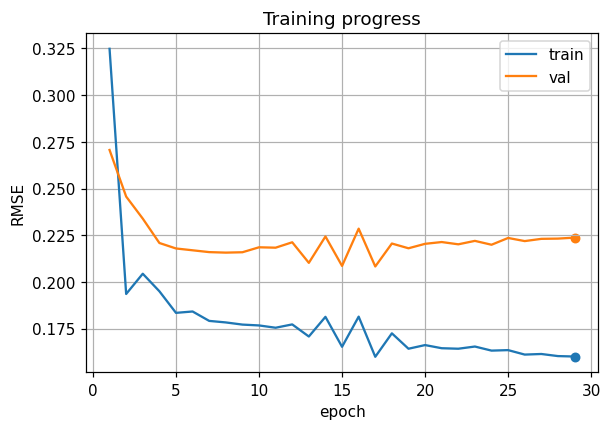

In [10]:

# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch and Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")


# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    device              = device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")
